# LSTM RNN

## Imports

In [54]:
import warnings
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import yfinance as yf
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

## Data

In [3]:
display_head_tail = lambda df: display(df.head(),df.tail())

In [4]:
etf_data = pd.read_csv('./Resources/Data/etf_data.csv', index_col='Date', parse_dates=True, infer_datetime_format=True)
display_head_tail(etf_data)

,ARKK,SPY,FNGU
Date,,,
2020-03-02,52.79,294.65,80.15
2020-03-03,51.73,286.22,73.85
2020-03-04,53.49,298.25,80.57
2020-03-05,52.24,288.33,73.80
2020-03-06,50.87,283.57,68.17


,ARKK,SPY,FNGU
Date,,,
2022-03-24,66.40,444.68,236.0
2022-03-25,64.51,446.85,233.4
2022-03-28,67.06,450.03,247.0
2022-03-29,71.39,455.59,257.7
2022-03-30,68.68,452.78,247.5


In [77]:
etf_data.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [5]:
arkk,spy,fngu = [etf_data[i].to_frame(i) for i in ['ARKK','SPY','FNGU']]

In [6]:
display_head_tail(arkk)

,ARKK
Date,
2020-03-02,52.79
2020-03-03,51.73
2020-03-04,53.49
2020-03-05,52.24
2020-03-06,50.87


,ARKK
Date,
2022-03-24,66.40
2022-03-25,64.51
2022-03-28,67.06
2022-03-29,71.39
2022-03-30,68.68


In [79]:
arkk.hvplot()

:Curve   [Date]   (ARKK)

In [7]:
display_head_tail(spy)

,SPY
Date,
2020-03-02,294.65
2020-03-03,286.22
2020-03-04,298.25
2020-03-05,288.33
2020-03-06,283.57


,SPY
Date,
2022-03-24,444.68
2022-03-25,446.85
2022-03-28,450.03
2022-03-29,455.59
2022-03-30,452.78


In [81]:
spy.hvplot()

:Curve   [Date]   (SPY)

In [8]:
display_head_tail(fngu)

,FNGU
Date,
2020-03-02,80.15
2020-03-03,73.85
2020-03-04,80.57
2020-03-05,73.80
2020-03-06,68.17


,FNGU
Date,
2022-03-24,236.0
2022-03-25,233.4
2022-03-28,247.0
2022-03-29,257.7
2022-03-30,247.5


In [80]:
fngu.hvplot()

:Curve   [Date]   (FNGU)

## Scaling Data

In [9]:
dataframes = [arkk,spy,fngu]

In [10]:
arkk_scaler, spy_scaler, fngu_scaler = [MinMaxScaler(feature_range=(0,1)).fit(i) for i in dataframes]

In [11]:
arkk_array, spy_array, fngu_array = [i.values for i in dataframes]

In [12]:
get_scaled = lambda scaler, array: scaler.transform(array)
arkk_scaled, spy_scaled, fngu_scaled = get_scaled(arkk_scaler,arkk_array),get_scaled(spy_scaler,arkk_array),get_scaled(fngu_scaler,fngu_array);

## Train Test Split

In [13]:
forecast_length = 60
training_length = len(etf_data) - forecast_length

In [14]:
def train_test_split_reshape(scaled_data, array):
    X, y = scaled_data[0:training_length, :], scaled_data[training_length - forecast_length:, :]

    X_train, X_test, y_train, y_test = [],[],[], array[training_length:, :]

    for i in range(forecast_length, len(X)):
        X_train.append(X[i-forecast_length:i, 0])
        y_train.append(X[i,0])

    for i in range(forecast_length, len(y)):
        X_test.append(y[i-forecast_length:i, 0])
        
    X_train, X_test, y_train = np.array(X_train), np.array(X_test), np.array(y_train)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return [X_train, X_test, y_train, y_test]

In [15]:
arkk_X_train, arkk_X_test, arkk_y_train, arkk_y_test =  train_test_split_reshape(arkk_scaled, arkk_array)
spy_X_train, spy_X_test, spy_y_train, spy_y_test = train_test_split_reshape(spy_scaled, spy_array)
fngu_X_train, fngu_X_test, fngu_y_train, fngu_y_test = train_test_split_reshape(fngu_scaled, fngu_array)

## Create Models

In [16]:
def get_model(n_layer1, n_layer2, n_layer3, X_train, optimizer, loss_func):
    model = Sequential()
    
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    display(model.summary())
    
    model.compile(optimizer=optimizer, loss=loss_func)
    
    return model

In [17]:
arkk_model = get_model(50,50,25,arkk_X_train,'adam','mse')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


None

In [18]:
spy_model = get_model(50,50,25,spy_X_train,'adam','mse')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


None

In [19]:
fngu_model = get_model(50,50,25,fngu_X_train,'adam','mse')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


None

## Train Models

In [20]:
arkk_model.fit(arkk_X_train, arkk_y_train, batch_size=1, epochs=1);

406/406 [==============================] - 6s 11ms/step - loss: 0.0078


In [21]:
spy_model.fit(spy_X_train, spy_y_train, batch_size=1, epochs=1);

406/406 [==============================] - 6s 11ms/step - loss: 0.0028


In [22]:
fngu_model.fit(fngu_X_train, fngu_y_train, batch_size=1, epochs=1);

406/406 [==============================] - 6s 11ms/step - loss: 0.0115


## Predict/Forecast

In [23]:
arkk_predictions = arkk_model.predict(arkk_X_test)


2/2 [==============================] - 0s 7ms/step


In [ ]:
spy_predictions = spy_model.predict(spy_X_test)

In [ ]:
fngu_predictions = fngu_model.predict(fngu_X_test)

### Actual vs Predicted 

In [34]:
def get_actual_predicted(df, predictions, scaler): 
    valid = df[training_length:]
    column_name = df.columns[0]
    valid[f'{column_name} Forecasted Adjusted Close'] = scaler.inverse_transform(predictions)
    valid[f'{column_name} Forecasted Adjusted Close'] = valid[f'{column_name} Forecasted Adjusted Close'].apply(lambda x: round(x,2))
    valid.rename(columns={column_name:f'{column_name} Actual Adjusted Close'}, inplace=True)
    return valid

In [35]:
arkk_actual_predicted = get_actual_predicted(arkk,arkk_predictions,arkk_scaler)
display_head_tail(arkk_actual_predicted)

,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close
Date,,
2022-01-04,92.69,97.40
2022-01-05,86.12,97.28
2022-01-06,85.58,96.75
2022-01-07,84.42,95.94
2022-01-10,84.64,94.94


,ARKK Actual Adjusted Close,ARKK Forecasted Adjusted Close
Date,,
2022-03-24,66.40,64.99
2022-03-25,64.51,65.66
2022-03-28,67.06,66.25
2022-03-29,71.39,66.88
2022-03-30,68.68,67.67


In [36]:
spy_actual_predicted = get_actual_predicted(spy,spy_predictions,spy_scaler)
display_head_tail(spy_actual_predicted)

,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close
Date,,
2022-01-04,469.93,95.45
2022-01-05,460.90,95.31
2022-01-06,460.47,94.80
2022-01-07,458.65,94.08
2022-01-10,458.08,93.20


,SPY Actual Adjusted Close,SPY Forecasted Adjusted Close
Date,,
2022-03-24,444.68,64.36
2022-03-25,446.85,64.88
2022-03-28,450.03,65.33
2022-03-29,455.59,65.83
2022-03-30,452.78,66.52


In [37]:
fngu_actual_predicted = get_actual_predicted(fngu,fngu_predictions,fngu_scaler)
display_head_tail(fngu_actual_predicted)

,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,
2022-01-04,380.4,381.89
2022-01-05,342.9,383.62
2022-01-06,349.1,381.93
2022-01-07,342.4,379.08
2022-01-10,344.2,375.20


,FNGU Actual Adjusted Close,FNGU Forecasted Adjusted Close
Date,,
2022-03-24,236.0,208.89
2022-03-25,233.4,215.65
2022-03-28,247.0,222.03
2022-03-29,257.7,228.65
2022-03-30,247.5,235.64


## Visualization

### Actual vs Predicted 

In [45]:
arkk_actual_predicted.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [46]:
spy_actual_predicted.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [47]:
fngu_actual_predicted.hvplot() 

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [62]:
arkk_actual_predicted.hvplot() * spy_actual_predicted.hvplot() * fngu_actual_predicted.hvplot()

:Overlay
   .NdOverlay.I   :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .NdOverlay.II  :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .NdOverlay.III :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [59]:
def display_heatmap(df, title):
    # Create correlation matrix DataFrame
    correlation_df = df.corr()
    
    # Save figure
    fig = plt.figure(figsize=(15,8))
    # Set title
    plt.title(title, fontsize=15, fontweight='bold')
    # Generate heatmap plot          
    sns.heatmap(correlation_df,
                    cbar_kws={'shrink': .5},
                    mask=np.triu(np.ones_like(correlation_df, dtype=bool)),
                    vmin=-1,
                    vmax=1,
                    center=0,
                    cmap='vlag', 
                    linewidth=1,
                    square=True).set(xlabel='Categories',
                                     ylabel='Categories');

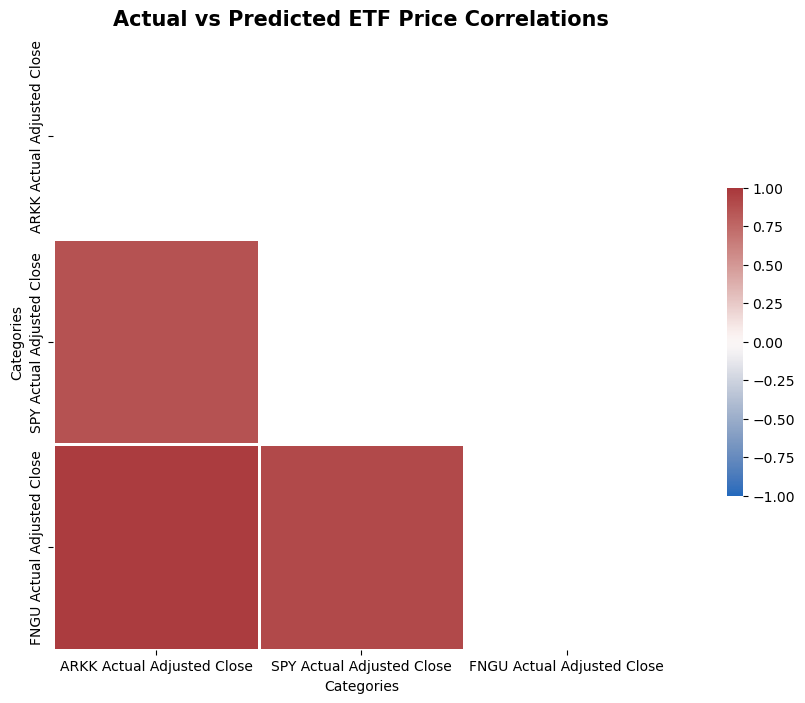

In [64]:
actual = pd.concat([arkk_actual_predicted.iloc[:,0],spy_actual_predicted.iloc[:,0],fngu_actual_predicted.iloc[:,0]], join='inner', axis=1)
display_heatmap(actual, 'Actual ETF Price Correlations')

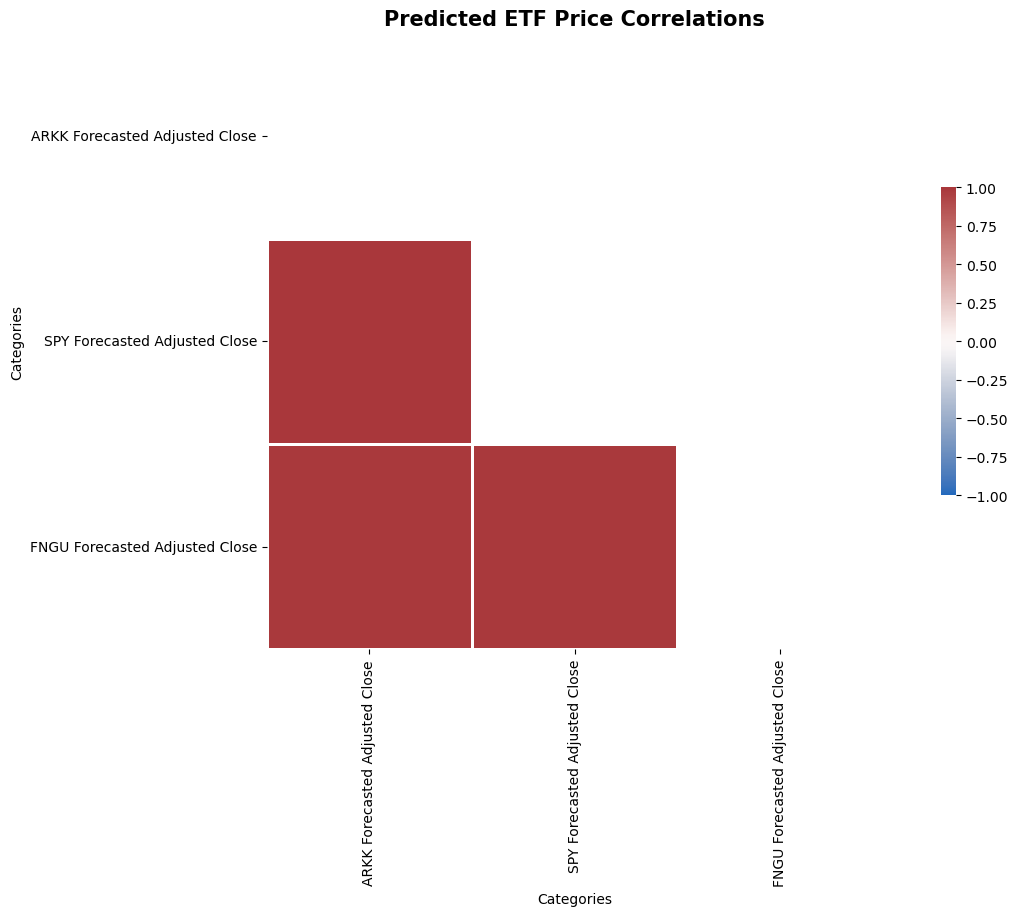

In [66]:
predicted = pd.concat([arkk_actual_predicted.iloc[:,1],spy_actual_predicted.iloc[:,1],fngu_actual_predicted.iloc[:,1]], join='inner', axis=1)
display_heatmap(predicted, 'Predicted ETF Price Correlations')

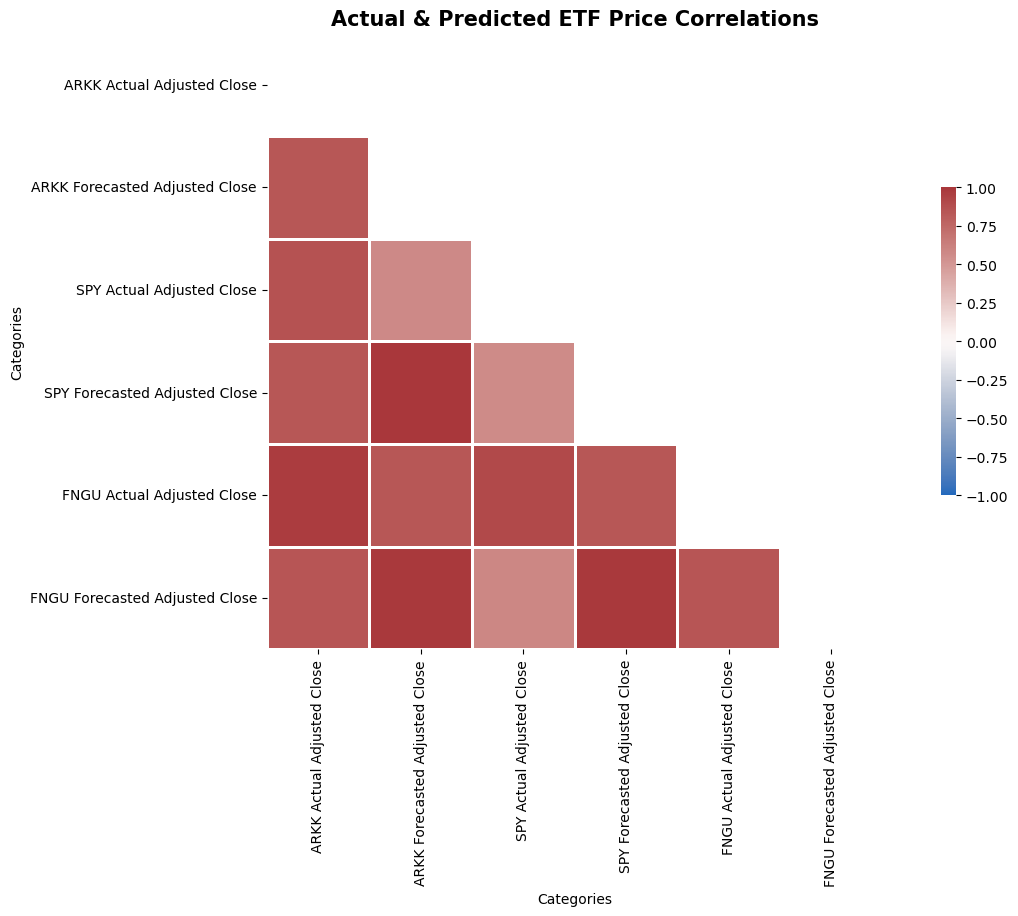

In [67]:
actual_predicted = pd.concat([arkk_actual_predicted,spy_actual_predicted,fngu_actual_predicted], join='inner', axis=1)
display_heatmap(actual_predicted, 'Actual & Predicted ETF Price Correlations')

### Training Data vs Actual vs Predicted

## Evaluation

In [73]:
print_rmse = lambda ticker, predictions, y_test: print(f'{ticker} Root Mean Square Error: {round(np.sqrt(np.mean(predictions - y_test)**2),2)}') 

ARKK Root Mean Square Error: 69.84


In [75]:
print_get_rmse('SPY',spy_predictions,spy_y_test)

SPY Root Mean Square Error: 438.21


In [76]:
print_rmse('FNGU', fngu_predictions,fngu_y_test)}')

FNGU Root Mean Square Error: 246.19


## Write-Up/Conclusion